In [2]:
import pandas as pd
from langdetect import detect
from langdetect import detect_langs
import deepl
import matplotlib.pyplot as plt

In [3]:
#read data
tracks= pd.read_csv('data/spotify_tracks.csv')
#get column names
columns = tracks.columns
columns

Index(['Unnamed: 0', 'acousticness', 'album_id', 'analysis_url', 'artists_id',
       'available_markets', 'country', 'danceability', 'disc_number',
       'duration_ms', 'energy', 'href', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'lyrics', 'mode', 'name', 'playlist',
       'popularity', 'preview_url', 'speechiness', 'tempo', 'time_signature',
       'track_href', 'track_name_prev', 'track_number', 'uri', 'valence',
       'type'],
      dtype='object')

In [4]:
#replace \r\n' with  ' '
tracks['lyrics']=tracks['lyrics'].str.replace('\r\n', ' ')
#drop 
tracks=tracks.dropna(subset=['lyrics'])
#Remove rows of repeating lyrics
tracks = tracks.drop_duplicates(subset='lyrics', keep='first').reset_index()

In [5]:
#function to detect the language
def detect_language_and_confidence(df, column_name):
    def get_lang_confidence(text):
        try:
            detected = detect_langs(text)
            # Assuming the most probable language is the one we want
            lang = detected[0].lang
            conf = detected[0].prob
            return lang, conf
        except:
            return 'unknown', None
    #write language and confidence to new df column
    df['language'], df['confidence'] = zip(*df[column_name].map(get_lang_confidence))
    
    return df

In [6]:
#execute function
lyrics_lang=detect_language_and_confidence(tracks,'lyrics')
c1=lyrics_lang.columns[0]
#drop double index
tracks_lang = lyrics_lang.drop(columns=c1)

In [12]:
#get number of tracks
len(tracks_lang)

40816

In [11]:
#number of tracks per language
tracks['language'].value_counts().head(10)

en    25722
es     6072
pt     1949
fr     1433
de      882
fi      754
it      741
sv      677
da      535
nl      450
Name: language, dtype: int64

In [14]:
#filter out the english songs
tracks_non_en=tracks[tracks['language'] != 'en']

In [69]:
#try to translate tracks into english using deepl api
auth_key = ""  # Replace with key
translator = deepl.Translator(auth_key)

tracks_non_en['lyrics_trans'] = tracks_non_en['lyrics'].apply(lambda x: translator.translate_text(x,  
               target_lang="EN-US") if type(x) == str else x)

The translation did not work because the free API version of deepl has a limit of 500.000 characters per month. The pro version costs 4.99€ per month + usage costs, which are 20€ per 1.000.000 characters. As you will see below the number of charactes in the lyrics of non-english songs exceeds this number by far.

In [17]:
#Number of characters in lyrics of non-english songs
sum(tracks_non_en['lyrics'].str.len())

22781178

In [21]:
lengths = tracks_non_en['lyrics'].str.len()

# Filter lengths that are between 1000 & 3000 characters
selected_lengths = lengths[(lengths >= 1000) & (lengths <= 3000)]

# Sum the selected lengths
total_length = selected_lengths.sum()

print(total_length)

15958773


Text(0, 0.5, 'Number of Entries')

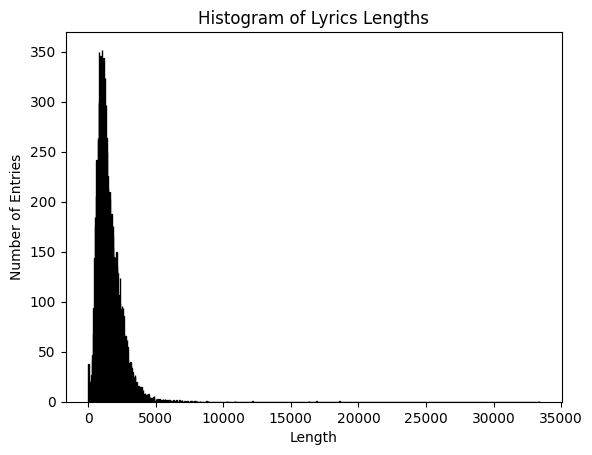

In [22]:
lengths = tracks_non_en['lyrics'].str.len()

# Create a histogram of the lengths
plt.hist(lengths, bins=1000, color='blue', edgecolor='black')
plt.title("Histogram of Lyrics Lengths")
plt.xlabel("Length")
plt.ylabel("Number of Entries")

# Show the plot

We tried to limit the number of songs to translate based on duration, number of characters, language but we couldn't find a combination that would stay below 500.000 characters and make sense to translate. That's why we decided to work only with the english songs.

In [ ]:
#save the df with the corresponding langauge as csv,
#so we don't have to load the whole csv in further steps
tracks_lang.to_csv('data/tracks_spotify_lang.csv', index=False)